 ## Defining the problem and assembling a dataset

- Tensorflow Cats Vs Dogs Dataset
  - https://www.tensorflow.org/datasets/catalog/cats_vs_dogs
- Binary Classification Problem

 ## Choosing a measure of success

- Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation and test sets
- Doing K-fold cross-validation

## Preparing your data

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATASET = 'cats_vs_dogs'
RESIZE = (32, 32, 3)
GRAY_SCALE = True

In [3]:
ds = tfds.load(DATASET, split='all', shuffle_files=True)

images, labels = [], []
for entry in ds.take(len(ds)) :
    image, label = entry['image'], entry['label']
    
    image, label = image.numpy(), label.numpy()
    
    image = resize(image, RESIZE, anti_aliasing=True)
            
    if GRAY_SCALE :
        image = rgb2gray(image)
        
    images.append( image )
    labels.append( label )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteXQKKC5/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
# list of images to numpy array
X = np.array(images)

# flatten 2D image array to 1D array
X = X.reshape( (X.shape[0], -1) )

# binary output, 0 or 1
y = np.array(labels)

In [5]:
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, 
                                                    random_state=SEED, shuffle=True)

In [6]:
# normalise pixels from [0, 255] to [0, 1]
X_train, X_test = X_train/255, X_test/255

In [7]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [8]:
# number of samples per each class
# we consider this to be a balanced class since the counts are about the same
np.sum(y), len(y)-np.sum(y)

(11604, 11658)

In [9]:
# the class is off-balanced, but very minimal 
baseline = (len(y)-np.sum(y)) / len(y)

baseline

0.5011606912561258

In [10]:
balanced_accuracy_baseline = balanced_accuracy_score(y_train, np.ones(len(y_train)))

balanced_accuracy_baseline

0.5

In [11]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [12]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y,
                              class_weights,
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        class_weight=class_weights,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [13]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'RMSprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [14]:
learning_rate = 0.005

slp_model = deep_neural_network(hidden_layers=0, hidden_neurons=64,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [15]:
batch_size = 128
EPOCHS = 500

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [16]:
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))

CLASS_WEIGHTS

{0: 0.9976410036457216, 1: 1.002370178840767}

In [17]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              class_weights=CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [18]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_slp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Validation): 0.58 (baseline=0.50)
Precision (Validation): 0.58
Recall (Validation): 0.58
AUC (Validation): 0.60


In [19]:
preds = trained_slp_model['model'].predict(X_val, verbose=0)

print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32')), balanced_accuracy_baseline))

Balanced Accuracy (Validation): 0.58 (baseline=0.50)


In [20]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

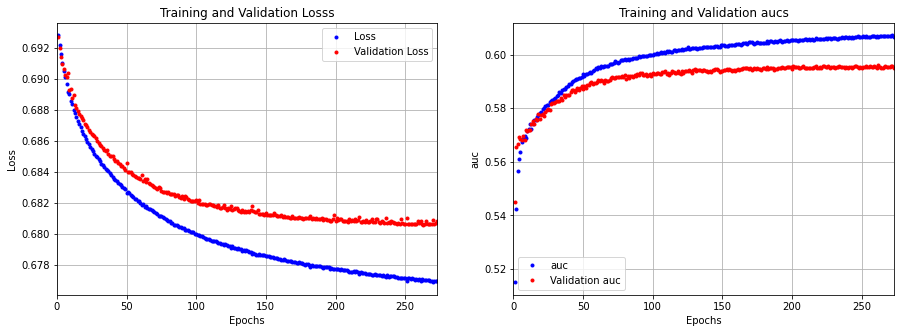

In [21]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [22]:
learning_rate = 0.001

mlp_model = deep_neural_network(hidden_layers=1, hidden_neurons=64,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                loss=LOSS_FUNC, metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                65600     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 65,665
Trainable params: 65,665
Non-trainable params: 0
_________________________________________________________________


In [23]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              class_weights=CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

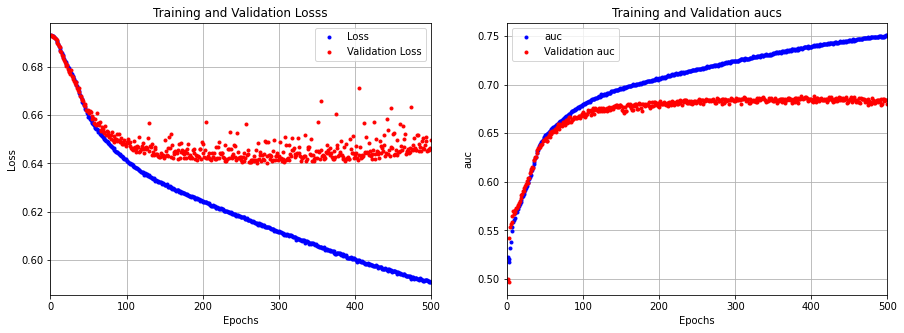

In [24]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [25]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_mlp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Validation): 0.62 (baseline=0.50)
Precision (Validation): 0.60
Recall (Validation): 0.71
AUC (Validation): 0.68


 ## Regularizing your model and tuning your hyperparameters

In [26]:
# Reformat Grid CV Stats to Dataframe
def to_dataframe(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

In [31]:
# Grid Search CV
def grid_search_cv(X, y, class_weights,
                   space, cv, 
                   learning_rate, loss, metrics, 
                   epochs, callbacks=[], seed=0, 
                   order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y) :
            model = deep_neural_network(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        output_dimension=1 if len(y.shape)<2 else y.shape[1],
                                        optimizer=RMSprop(learning_rate=learning_rate), 
                                        loss=loss, metrics=metrics)
      
            trained = train_deep_neural_network(model, 
                                                X[train,:], y[train], 
                                                class_weights=class_weights,
                                                batch_size=params['batch_size'], epochs=epochs, 
                                                val_data=(X[validate,:], y[validate]), 
                                                callbacks=callbacks, seed=seed) 
            
            evaluations = trained['model'].evaluate(X[validate,:], y[validate], verbose=0)[1:]
                        
            scores.append( evaluations )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return to_dataframe(stats, order)

In [32]:
orders = {
    0: 'accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
}

In [33]:
KFOLDS = 5

In [34]:
params = {
    'hidden_layers': [1, 2],
    'neurons': [64],
    'activation': ['relu'],
    'dropout': [0.2],
    'batch_size': [128]
}

learning_rate = 0.001
epochs = 1000

stats = grid_search_cv(X_train, y_train,  
                       class_weights=CLASS_WEIGHTS,
                       space=params, cv=KFOLDS, 
                       learning_rate=learning_rate, 
                       loss=LOSS_FUNC, metrics=METRICS, 
                       epochs=epochs, callbacks=[EARLY_STOP], seed=SEED,
                       order=orders)

In [35]:
stats.sort_values(by=['auc'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,accuracy,precision,recall,auc
1,2,64,relu,0.2,128,87.4,0.643098,0.626989,0.613301,0.684445,0.676842
0,1,64,relu,0.2,128,222.8,0.644554,0.622314,0.611816,0.665590,0.673203


In [40]:
learning_rate = 0.0025

opt_model = deep_neural_network(hidden_layers=1, hidden_neurons=64,
                                dropout=0.2, activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                loss=LOSS_FUNC, metrics=METRICS,
                                name='Deep_Wide_Network')

opt_model.summary()

Model: "Deep_Wide_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 64)                65600     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 65,665
Trainable params: 65,665
Non-trainable params: 0
_________________________________________________________________


In [41]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              class_weights=CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

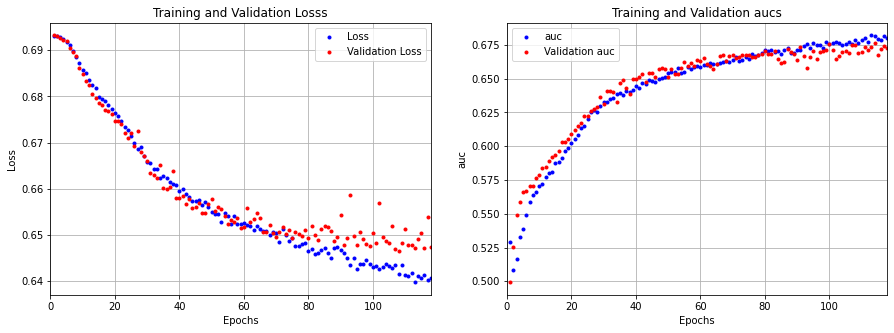

In [42]:
plot_training_history(trained_opt_model['history'], monitors=['loss', 'auc'])

In [43]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.63 (baseline=0.50)
Precision (Validation): 0.61
Recall (Validation): 0.68
AUC (Validation): 0.67


In [47]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(accuracy_score(y_test, (preds > 0.5).astype('int32')), baseline))
print('Precision (Test): {:.2f}'.format(precision_score(y_test, (preds > 0.5).astype('int32'))))
print('Recall (Test): {:.2f}'.format(recall_score(y_test, (preds > 0.5).astype('int32'))))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, preds)))

Accuracy (Test): 0.63 (baseline=0.50)
Precision (Test): 0.62
Recall (Test): 0.70
AUC (Test): 0.68


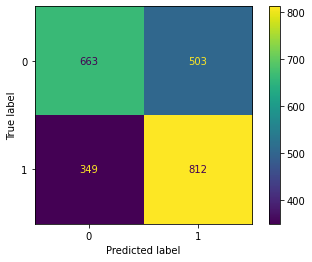

In [54]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test, (preds > 0.5).astype('int32')) )
_ = disp.plot()